In [1]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
import sys

sys.path.append('../../')

from nc_explorer import NcExplorer
from tsgen import TsGenerator

tsg = TsGenerator()
exp = NcExplorer()

Declaring class instance from: S3-FRBR:Nc_Explorer
Input NetCDF file folde not set. Proceed at your own risk.
Declaring class instance from: S3-FRBR:Nc_Explorer
Input NetCDF file folde not set. Proceed at your own risk.


In [3]:
exp.s3_bands_l2

{'Oa01': 400,
 'Oa02': 412.5,
 'Oa03': 442.5,
 'Oa04': 490,
 'Oa05': 510,
 'Oa06': 560,
 'Oa07': 620,
 'Oa08': 665,
 'Oa09': 673.75,
 'Oa10': 681.25,
 'Oa11': 708.75,
 'Oa12': 753.75,
 'Oa16': 778.75,
 'Oa17': 865,
 'Oa18': 885,
 'Oa21': 1020}

In [4]:
win_dir = 'D:\processing\win\MANACAPURU'
unix_dir = '/d_drive_data/S3/L2_WFR_subset/MANACAPURU'

img = 'S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002_subset.txt'

full_path = os.path.join(unix_dir,img)
df = pd.read_csv(full_path,sep='\t',skiprows=1)

In [5]:
figdate = os.path.basename(full_path).split('____')[1].split('_')[0]
figdate

'20191104T135002'

Text(0, 0.5, 'LAT')

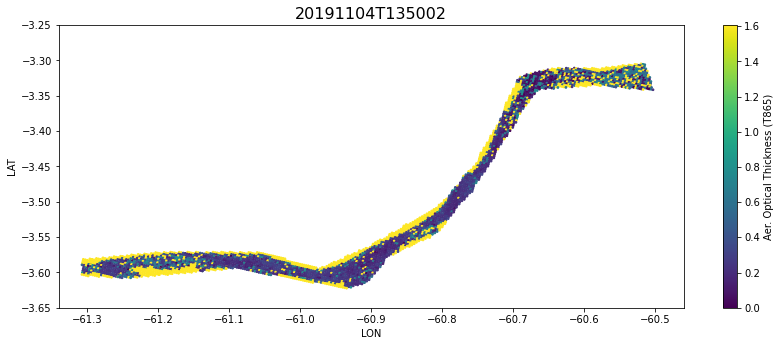

In [6]:
# Scatter MAP
plt.rcParams['figure.figsize'] = tsg.rcparam
fig = plt.figure()
ax = plt.axes()
ax.set_title(figdate, fontsize=16)
sktmap = ax.scatter(df['longitude:double'], df['latitude:double'], c=df['T865:float'], cmap='viridis', s=3)
cbar = fig.colorbar(sktmap, ax=ax)
cbar.set_label('Aer. Optical Thickness (T865)')

ax.set_xlim(-61.34, -60.46)
ax.set_ylim(-3.65, -3.25)
ax.set_xlabel('LON')
ax.set_ylabel('LAT')

## Filtering parameters

In [7]:
# Delete indexes for which Oa01_reflectance is saturated:
indexNames = df[df['Oa01_reflectance:float'] == 1.0000184].index
df.drop(indexNames, inplace=True)

# save the semi-raw DF for futher use
rdf = df.copy()

In [8]:
# Add new FLAGS and QUALITY cols
df = tsg.add_flags_to_df(df)

In [9]:
# Delete indexes for which QUALITY = 0
indexNames = df[df['QUALITY'] == 0].index
df.drop(indexNames, inplace=True)

In [10]:
# Delete indexes for which FLAGS = False
indexNames = df[df['FLAGS'] == False].index
df.drop(indexNames, inplace=True)

In [11]:
# Get names of indexes for which T865 (Aerosol optical depth) is thicker than 0.6
indexNames = df[df['T865:float'] >= 0.6].index
# Delete these row indexes from dataFrame
df.drop(indexNames, inplace=True)

In [12]:
################################
# FILTER NEGATIVE REFLECTANCES #
################################
df.loc[df['Oa01_reflectance:float'] < 0, 'Oa01_reflectance:float'] = np.nan
df.loc[df['Oa02_reflectance:float'] < 0, 'Oa02_reflectance:float'] = np.nan
df.loc[df['Oa03_reflectance:float'] < 0, 'Oa03_reflectance:float'] = np.nan
df.loc[df['Oa04_reflectance:float'] < 0, 'Oa04_reflectance:float'] = np.nan
df.loc[df['Oa05_reflectance:float'] < 0, 'Oa05_reflectance:float'] = np.nan
df.loc[df['Oa06_reflectance:float'] < 0, 'Oa06_reflectance:float'] = np.nan
df.loc[df['Oa07_reflectance:float'] < 0, 'Oa07_reflectance:float'] = np.nan
df.loc[df['Oa08_reflectance:float'] < 0, 'Oa08_reflectance:float'] = np.nan
df.loc[df['Oa09_reflectance:float'] < 0, 'Oa09_reflectance:float'] = np.nan
df.loc[df['Oa10_reflectance:float'] < 0, 'Oa10_reflectance:float'] = np.nan
df.loc[df['Oa11_reflectance:float'] < 0, 'Oa11_reflectance:float'] = np.nan
df.loc[df['Oa12_reflectance:float'] < 0, 'Oa12_reflectance:float'] = np.nan
df.loc[df['Oa16_reflectance:float'] < 0, 'Oa16_reflectance:float'] = np.nan
df.loc[df['Oa17_reflectance:float'] < 0, 'Oa17_reflectance:float'] = np.nan
df.loc[df['Oa18_reflectance:float'] < 0, 'Oa18_reflectance:float'] = np.nan
df.loc[df['Oa21_reflectance:float'] < 0, 'Oa21_reflectance:float'] = np.nan

###############################
# DROP EVERY NAN REFLECTANCES #
###############################
df = df.dropna()

In [13]:
# Filter reflectances that do not have the "V-shape"

# Oa16 must always be above Oa12, for Oa12 is an atmospheric attenuation window
df = df[df['Oa16_reflectance:float'] > df['Oa12_reflectance:float']]
# Oa11 must always be higher than Oa12
df = df[df['Oa11_reflectance:float'] > df['Oa12_reflectance:float']]

In [14]:
# Calculate GLINT
print('Calculating GLINT column...')
df = tsg.get_glint(df)

Calculating GLINT column...


## Applying KDE
#### In order to be KDE-compatible, the DF must have at least 3 pixels left after the filtering:

In [15]:
len(df)

369

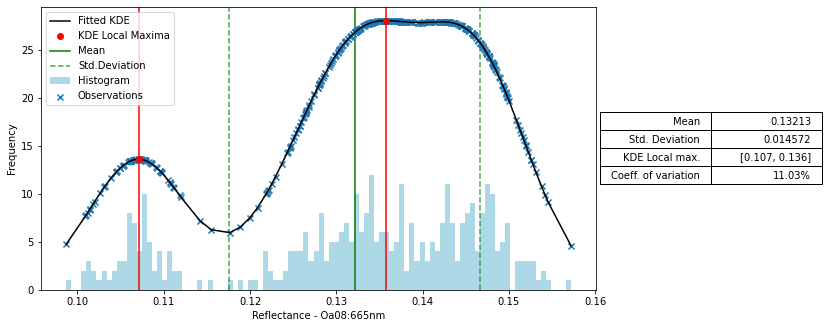

In [16]:
x = df['Oa08_reflectance:float'].copy()
pk, xray, yray, kde_res = tsg.kde_local_maxima(x)

tsg.plot_kde_histntable(xray=xray,
                        yray=yray,
                        x=x,
                        kde_res=kde_res,
                        pk=pk)

In [17]:
xmean = np.mean(x)
kdemaxes = [m for m in xray[pk]]
kdemaxes.append(xmean)
drop_threshold = min(kdemaxes)
drop_threshold_upper_lim = drop_threshold + (0.1 * drop_threshold)
# drop_threshold_upper_lim = drop_threshold + (0.25 * drop_threshold)

# drop_threshold_lower_lim = drop_threshold - (0.25 * drop_threshold)

# Drop data outside bounds for drop_threshold:
indexNames = df[df['Oa08_reflectance:float'] > drop_threshold_upper_lim].index
kdf = df.copy()
kdf.drop(indexNames, inplace=True)
# indexNames = df[df['Oa08_reflectance:float'] < drop_threshold_lower_lim].index
# df.drop(indexNames, inplace=True)

#####################################
# Fix the indexing of the dataframe #
#####################################
df.reset_index(drop=True, inplace=True)
kdf.reset_index(drop=True, inplace=True)

## KDE After the drop

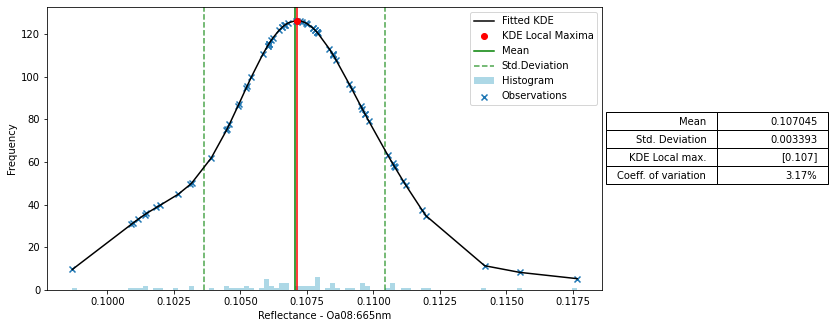

In [18]:
x = kdf['Oa08_reflectance:float'].copy()
pk, xray, yray, kde_res = tsg.kde_local_maxima(x)

tsg.plot_kde_histntable(xray=xray,
                        yray=yray,
                        x=x,
                        kde_res=kde_res,
                        pk=pk)

## Generating the report plots

In [19]:
# Reflectance
# tsg.s3l2_custom_reflectance_plot(df=kdf,
#                                  figure_title=figdate)

## Get the CAMS AOD over the corresponding date

In [20]:
import netCDF4

In [21]:
# WIN
# ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"
# LINUX
ncs = "/d_drive_data/git-repos/cams_visu/cams_visu/test_dl/cams_2019.nc"

cams_nc = netCDF4.Dataset(ncs,'r')

# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time']

# creating 2D grids for further plotting
lon_grid, lat_grid = np.meshgrid(lons, lats)

In [22]:
time[1230]

masked_array(data=1050516,
             mask=False,
       fill_value=999999,
            dtype=int32)

In [23]:
nc_date = str(netCDF4.num2date(time[1230], time.units, time.calendar))
nc_date

'2019-11-04 12:00:00'

In [24]:
# get the total Aerosol Optical Depth at 865nm 
aod_band = cams_nc.variables['aod865'][1230][:]

In [25]:
# Manacapuru Centroid
query_lon, query_lat = -60.8911, -3.5726

In [26]:
query_aod = exp.get_point_data_in_single_band(aod_band,
                                              lon=lon_grid,
                                              lat=lat_grid,
                                              target_lon=query_lon,
                                              target_lat=query_lat)[1]
query_aod

0.3127664394840741

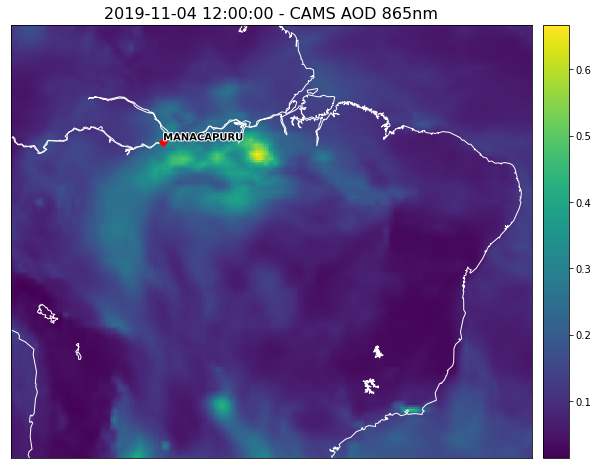

In [27]:
import matplotlib.patheffects as PathEffects
from mpl_toolkits.basemap import Basemap

# Make this plot larger.
plt.figure(figsize=(10,8))

plt.title(f'{nc_date} - CAMS AOD 865nm', fontsize=16)

# Miller projection:
m = Basemap(projection='mill',
            lat_ts=10,
            llcrnrlon=lon_grid.min(),
            urcrnrlon=lon_grid.max(),
            llcrnrlat=lat_grid.min(),
            urcrnrlat=lat_grid.max(),
            resolution='l')

m.drawcoastlines(color='white')

x, y = m(lon_grid, lat_grid)
plot_var = aod_band
m.pcolormesh(x, y, plot_var, shading='flat') # cmap=plt.cm.gray
m.colorbar(location='right')


xpt, ypt = m(query_lon,query_lat)
m.plot(xpt, ypt, 'rD')
txt = plt.text(xpt, ypt, f'MANACAPURU',fontsize=10,fontweight='bold',
                ha='left',va='bottom',color='k')
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.savefig('CAMS_manaca.png', bbox_inches='tight')
plt.show()

In [28]:
rdf['minus_cams'] = rdf['T865:float'] - query_aod

Text(0, 0.5, 'LAT')

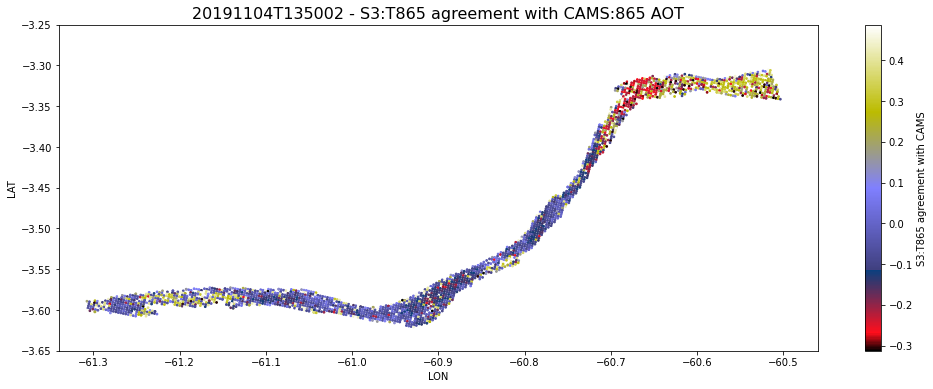

In [29]:
# Scatter MAP
plt.rcParams['figure.figsize'] = [17, 6]
fig = plt.figure()
ax = plt.axes()
ax.set_title(f'{figdate} - S3:T865 agreement with CAMS:865 AOT', fontsize=16)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['T865:float'], cmap='viridis', s=3)

sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='gist_stern', s=3)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='viridis', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='Greys_r', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='terrain', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='cubehelix', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='gist_rainbow', s=3)

cbar = fig.colorbar(sktmap, ax=ax)
# cbar.set_label('Aer. Optical Thickness (T865)')
cbar.set_label('S3:T865 agreement with CAMS')

ax.set_xlim(-61.34, -60.46)
ax.set_ylim(-3.65, -3.25)
ax.set_xlabel('LON')
ax.set_ylabel('LAT')

## Report plots

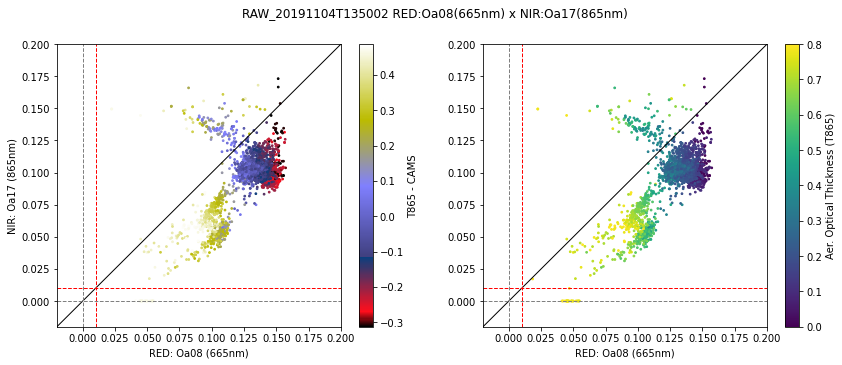

In [30]:
# RAW Scatter
tsg.plot_sidebyside_sktr(x1_data=rdf['Oa08_reflectance:float'],
                         y1_data=rdf['Oa17_reflectance:float'],
                         x2_data=rdf['Oa08_reflectance:float'],
                         y2_data=rdf['Oa17_reflectance:float'],
                         x_lbl='RED: Oa08 (665nm)',
                         y_lbl='NIR: Oa17 (865nm)',
                         c1_data=rdf['minus_cams'],
                         c1_lbl='T865 - CAMS',
                         c2_data=rdf['T865:float'],
                         c2_lbl='Aer. Optical Thickness (T865)',
                         cmap1='gist_stern',
                         title=f'RAW_{figdate} RED:Oa08(665nm) x NIR:Oa17(865nm)')

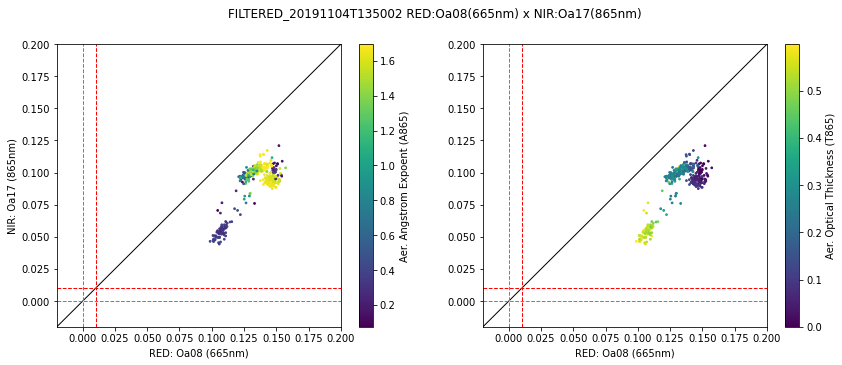

In [31]:
# Filtered scatter
tsg.plot_sidebyside_sktr(x1_data=df['Oa08_reflectance:float'],
                         y1_data=df['Oa17_reflectance:float'],
                         x2_data=df['Oa08_reflectance:float'],
                         y2_data=df['Oa17_reflectance:float'],
                         x_lbl='RED: Oa08 (665nm)',
                         y_lbl='NIR: Oa17 (865nm)',
                         c1_data=df['A865:float'],
                         c1_lbl='Aer. Angstrom Expoent (A865)',
                         c2_data=df['T865:float'],
                         c2_lbl='Aer. Optical Thickness (T865)',
                         title=f'FILTERED_{figdate} RED:Oa08(665nm) x NIR:Oa17(865nm)')

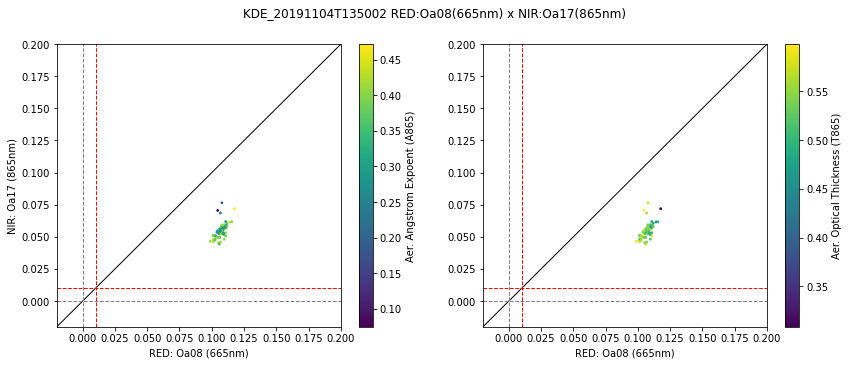

In [32]:
# Filtered scatter + KDE
tsg.plot_sidebyside_sktr(x1_data=kdf['Oa08_reflectance:float'],
                         y1_data=kdf['Oa17_reflectance:float'],
                         x2_data=kdf['Oa08_reflectance:float'],
                         y2_data=kdf['Oa17_reflectance:float'],
                         x_lbl='RED: Oa08 (665nm)',
                         y_lbl='NIR: Oa17 (865nm)',
                         c1_data=kdf['A865:float'],
                         c1_lbl='Aer. Angstrom Expoent (A865)',
                         c2_data=kdf['T865:float'],
                         c2_lbl='Aer. Optical Thickness (T865)',
                         title=f'KDE_{figdate} RED:Oa08(665nm) x NIR:Oa17(865nm)')

Text(0, 0.5, 'LAT')

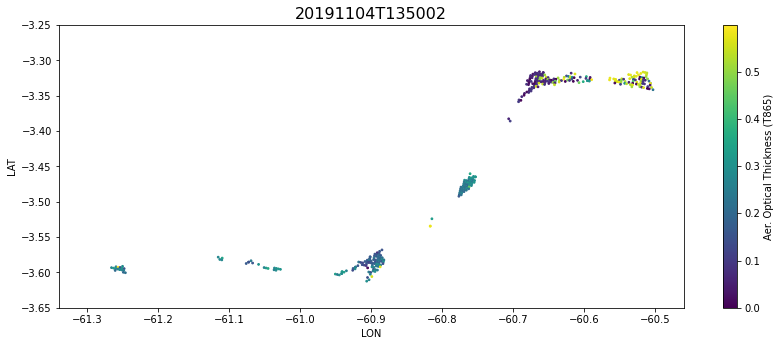

In [33]:
# Filtered scatter MAP
plt.rcParams['figure.figsize'] = tsg.rcparam
fig = plt.figure()
ax = plt.axes()
ax.set_title(figdate, fontsize=16)
sktmap = ax.scatter(df['longitude:double'], df['latitude:double'], c=df['T865:float'], cmap='viridis', s=3)
cbar = fig.colorbar(sktmap, ax=ax)
cbar.set_label('Aer. Optical Thickness (T865)')

ax.set_xlim(-61.34, -60.46)
ax.set_ylim(-3.65, -3.25)
ax.set_xlabel('LON')
ax.set_ylabel('LAT')

## Generating the parallel coordinates plot

In [34]:
df['minus_cams'] = df['T865:float'] - query_aod

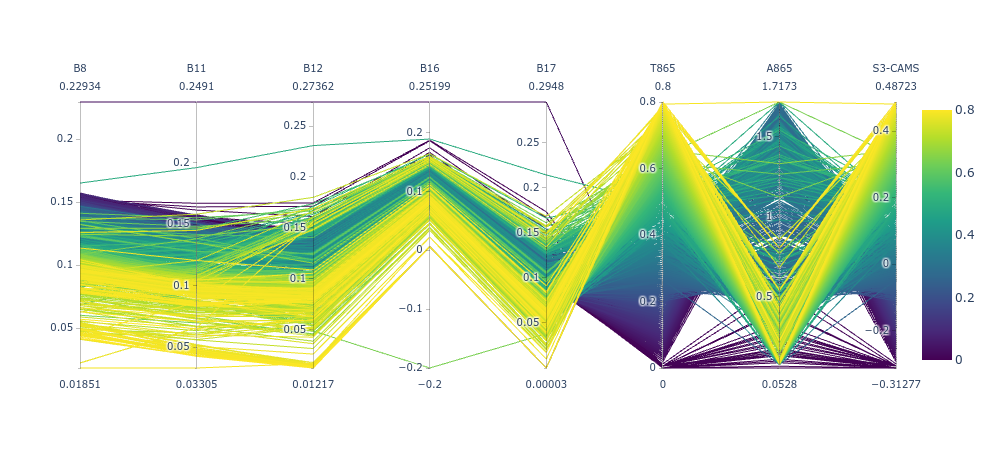

In [35]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = rdf['T865:float'],
                   colorscale = 'Viridis',
                   showscale = True),
        dimensions = list([
            dict(range = [rdf['Oa08_reflectance:float'].min(), rdf['Oa08_reflectance:float'].max()],
                 label = 'B8', values = rdf['Oa08_reflectance:float']),
            dict(range = [rdf['Oa11_reflectance:float'].min(), rdf['Oa11_reflectance:float'].max()],
                 label = 'B11', values = rdf['Oa11_reflectance:float']),
            dict(range = [rdf['Oa12_reflectance:float'].min(), rdf['Oa12_reflectance:float'].max()],
                 label = 'B12', values = rdf['Oa12_reflectance:float']),
            dict(range = [rdf['Oa16_reflectance:float'].min(), rdf['Oa16_reflectance:float'].max()],
                 label = 'B16', values = rdf['Oa16_reflectance:float']),
            dict(range = [rdf['Oa17_reflectance:float'].min(), rdf['Oa17_reflectance:float'].max()],
                 label = 'B17', values = rdf['Oa17_reflectance:float']),
            dict(range = [rdf['T865:float'].min() ,rdf['T865:float'].max()],
                 label = 'T865', values = rdf['T865:float']),
            dict(range = [rdf['A865:float'].min(), rdf['A865:float'].max()],
                 label = 'A865', values = rdf['A865:float']),
            dict(range = [rdf['minus_cams'].min(), rdf['minus_cams'].max()],
                 label = 'S3-CAMS', values = rdf['minus_cams'])
        ])    
    )
)

fig.show()

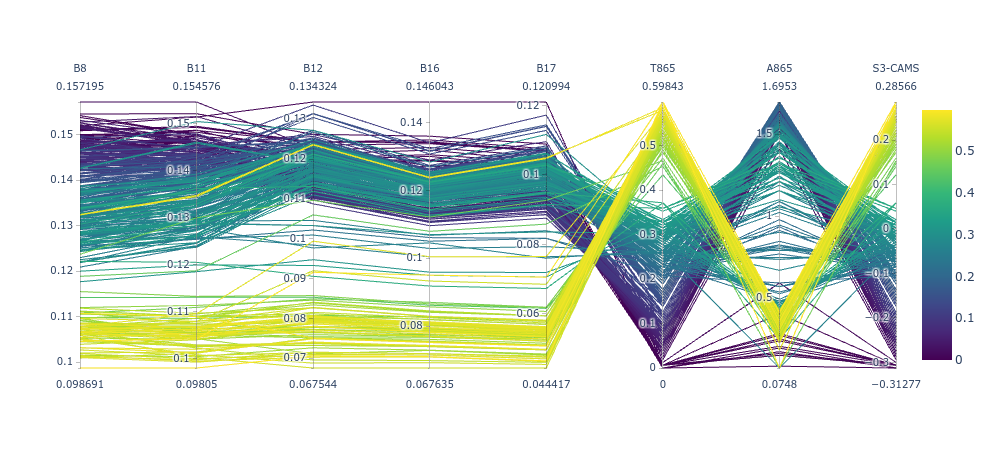

In [36]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['T865:float'],
                   colorscale = 'Viridis',
                   showscale = True),
        dimensions = list([
            dict(range = [df['Oa08_reflectance:float'].min(), df['Oa08_reflectance:float'].max()],
                 label = 'B8', values = df['Oa08_reflectance:float']),
            dict(range = [df['Oa11_reflectance:float'].min(), df['Oa11_reflectance:float'].max()],
                 label = 'B11', values = df['Oa11_reflectance:float']),
            dict(range = [df['Oa12_reflectance:float'].min(), df['Oa12_reflectance:float'].max()],
                 label = 'B12', values = df['Oa12_reflectance:float']),
            dict(range = [df['Oa16_reflectance:float'].min(), df['Oa16_reflectance:float'].max()],
                 label = 'B16', values = df['Oa16_reflectance:float']),
            dict(range = [df['Oa17_reflectance:float'].min(), df['Oa17_reflectance:float'].max()],
                 label = 'B17', values = df['Oa17_reflectance:float']),
            dict(range = [df['T865:float'].min() ,df['T865:float'].max()],
                 label = 'T865', values = df['T865:float']),
            dict(range = [df['A865:float'].min(), df['A865:float'].max()],
                 label = 'A865', values = df['A865:float']),
            dict(range = [df['minus_cams'].min(), df['minus_cams'].max()],
                 label = 'S3-CAMS', values = df['minus_cams'])
        ])    
    )
)

fig.show()

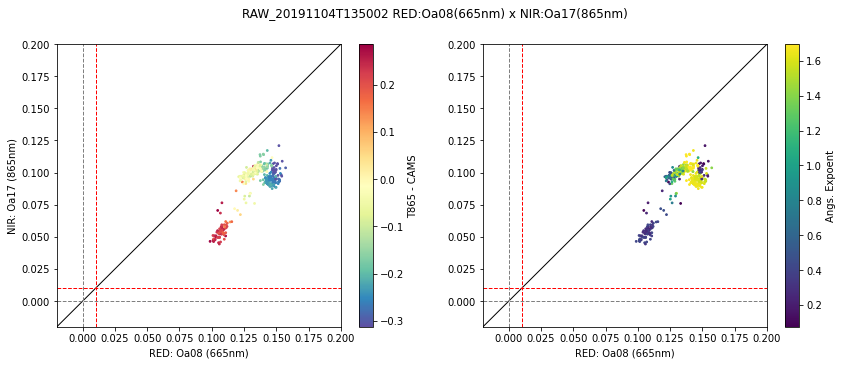

In [40]:
tsg.plot_sidebyside_sktr(x1_data=df['Oa08_reflectance:float'],
                         y1_data=df['Oa17_reflectance:float'],
                         x2_data=df['Oa08_reflectance:float'],
                         y2_data=df['Oa17_reflectance:float'],
                         x_lbl='RED: Oa08 (665nm)',
                         y_lbl='NIR: Oa17 (865nm)',
                         c1_data=df['minus_cams'],
                         c1_lbl='T865 - CAMS',
                         c2_data=df['A865:float'],
#                          c2_lbl='Aer. Optical Thickness (T865)',
                         c2_lbl='Angs. Expoent',
                         cmap1='Spectral_r',
                         title=f'RAW_{figdate} RED:Oa08(665nm) x NIR:Oa17(865nm)')

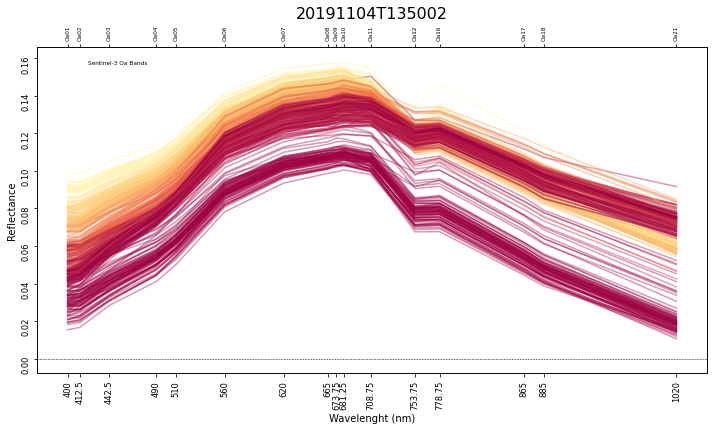

In [38]:
# Reflectance
tsg.s3l2_custom_reflectance_plot(df=df,
                                 figure_title=figdate)